# Import Libraries

The following NLTK Library Resources need to be downloaded in order to conduct the analysis and the machine learning models.

In [ ]:
# resources from library nltk to be downloaded
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

Import all required libraries

In [ ]:
# import libraries
import contractions
import gensim
import html
import keras_tuner as kt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf

from gensim.models import Word2Vec

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

# Loading Data from local folder

In [ ]:
# load data
train = pd.read_csv("Tweets_train.csv")
test = pd.read_csv("New_Tweets_test-1.csv")
dev = pd.read_csv("Tweets_dev.csv")

# Exploratory Data Analysis - Data Cleaning:
1. Check shape of the data
2. Check column data types
3. Check for Null values
4. Check for unique values of airline_sentiment
5. Check for duplicates

## 1. Check shape of the data

In [ ]:
# Check the shape of the data
print("Shape of Train data", train.shape)
print("Shape of Test data", test.shape) # extra index column present
print("Shape of Dev data", dev.shape)

In [ ]:
# remove extra index column in test data
test = test[['tweet_id', 'text', 'airline_sentiment']]

# Check the shape of test data
print("Shape of Test data", test.shape)

Shape of Test data (1464, 3)


## 2. Check column data types

In [ ]:
# Verifying column types
print("Train data column types:")
print(train.dtypes, "\n")
print("Test data column types:")
print(test.dtypes, "\n")
print("Dev data column types:")
print(dev.dtypes, "\n")

Train data column types:
tweet_id              int64
text                 object
airline_sentiment    object
dtype: object 

Test data column types:
tweet_id              int64
text                 object
airline_sentiment    object
dtype: object 

Dev data column types:
tweet_id              int64
text                 object
airline_sentiment    object
dtype: object 



## 3. Check for NULL Values

In [ ]:
# Checking for NULL values
print("Checking NULL values for train data:")
print(train.isnull().sum(), "\n")
print("Checking NULL values for test data:")
print(test.isnull().sum(), "\n")
print("Checking NULL values for dev data:")
print(dev.isnull().sum(), "\n")

## 4. Check for unique values of airline_sentiment

In [ ]:
# verify if airline_sentiment has only one of the following values: positive, negative, neutral
print("Unique values of airline_sentiment for Train data:")
print(train.airline_sentiment.unique() , "\n")
print("Unique values of airline_sentiment for Test data:")
print(test.airline_sentiment.unique(), "\n")
print("Unique values of airline_sentiment for Dev data:")
print(dev.airline_sentiment.unique(), "\n")

## 5. Check for duplicates

In [ ]:
# Check for duplicates in data
print("Number of duplicates in train data:", train.duplicated().sum())
print("Number of duplicates in test data:", test.duplicated().sum())
print("Number of duplicates in train data:", dev.duplicated().sum())

In [ ]:
# Removing duplicates
train_unique = train.drop_duplicates(ignore_index=True)
test_unique = test.drop_duplicates(ignore_index=True)
dev_unique = dev.drop_duplicates(ignore_index=True)

# Exploratory Data Analysis: Graphical and Numerical Summaries  
## 1. Number of negative, neutral and positive tweets in each dataset

In [ ]:
# Count of airline sentiment
print("Number of negative, neutral and positive sentiments in train data:")
print(train_unique['airline_sentiment'].value_counts(), "\n")

print("Number of negative, neutral and positive sentiments in test data:")
print(test_unique['airline_sentiment'].value_counts(), "\n")

print("Number of negative, neutral and positive sentiments in dev data:")
print(dev_unique['airline_sentiment'].value_counts(), "\n")

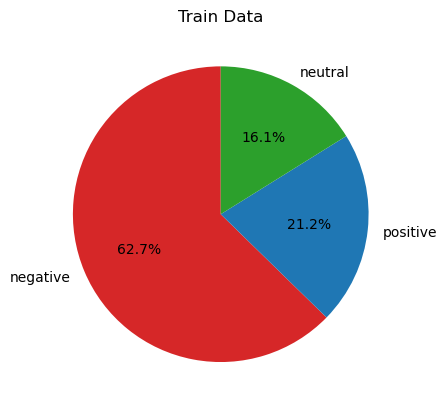

In [ ]:
# pie chart showing number of negative, positive and neutral tweets for train data set
train_count = train_unique['airline_sentiment'].value_counts()
plt.pie(train_count, startangle=90, autopct='%1.1f%%', labels=['negative','positive', 'neutral'], colors=['tab:red','tab:blue','tab:green'])
plt.title("Train Data")
plt.savefig('train-piechart.png')

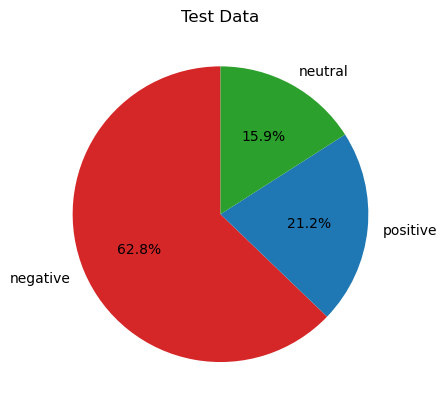

In [ ]:
# pie chart showing number of negative, positive and neutral tweets for test data
test_count = test_unique['airline_sentiment'].value_counts()
plt.pie(test_count, startangle=90, autopct='%1.1f%%', labels=['negative','positive', 'neutral'], colors=['tab:red','tab:blue','tab:green'])
plt.title("Test Data")
plt.savefig('test-piechart.png')

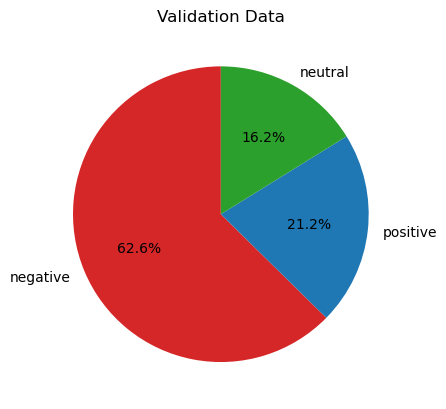

In [ ]:
# pie chart showing number of negative, positive and neutral tweets for dev data
dev_count = dev_unique['airline_sentiment'].value_counts()
plt.pie(dev_count,startangle=90, autopct='%1.1f%%', labels=['negative','positive', 'neutral'], colors=['tab:red','tab:blue','tab:green'])
plt.title("Validation Data")
plt.savefig('dev-piechart.png')

## 2. Number of positive, neutral and negative sentiments per airline for each dataset

Identifying airline company

In [ ]:
# Creating a function to identify the airline company for the data
def identify_airline(dataset):
    company = ['None'] * len(dataset)
    for i in range(len(dataset)):
        if str.lower(dataset['text'][i]).rfind('@united') != -1:
            company[i] = "united"
        elif str.lower(dataset['text'][i]).rfind('@americanair') != -1:
            company[i] = "americanair"
        elif str.lower(dataset['text'][i]).rfind('@jetblue') != -1:
            company[i] = "jetblue"
        elif str.lower(dataset['text'][i]).rfind('@usairways') != -1:
            company[i] = "usairways"
        elif str.lower(dataset['text'][i]).rfind('@virginamerica') != -1:
            company[i] = "virginamerica"
        elif str.lower(dataset['text'][i]).rfind('@southwestair') != -1:
            company[i] = "southwestair"
        elif str.lower(dataset['text'][i]).rfind('@deltaassist') != -1:
            company[i] = "deltaassist"
        elif str.lower(dataset['text'][i]).rfind('@shannonwoodward') != -1:
            company[i] = "shannonwoodward"
        elif str.lower(dataset['text'][i]).rfind('@ninadavuluri') != -1:
            company[i] = "ninadavuluri"
    return company

In [ ]:
def check_airline(company):
    if 'None' in company:
        print("Airline company has not been identified for one or more observations.")
    else:
        print("Airline company has been identified for all observations.")

In [ ]:
train_company = identify_airline(train_unique)
test_company = identify_airline(test_unique)
dev_company = identify_airline(dev_unique)

check_airline(train_company)
check_airline(test_company)
check_airline(dev_company)

Airline company has been identified for all observations.
Airline company has been identified for all observations.
Airline company has been identified for all observations.


In [ ]:
# insert data to the dataset
train_airline = train_unique.copy()
train_airline.insert(1,"airline_company", train_company)

test_airline = test_unique.copy()
test_airline.insert(1,"airline_company", test_company)

dev_airline = dev_unique.copy()
dev_airline.insert(1,"airline_company", dev_company)

In [ ]:
# number of tweets per airline for train set
united = train_airline.loc[train_airline['airline_company']=='united']
united_count = united['airline_sentiment'].value_counts()

americanair = train_airline.loc[train_airline['airline_company']=='americanair']
americanair_count = americanair['airline_sentiment'].value_counts()

jetblue = train_airline.loc[train_airline['airline_company']=='jetblue']
jetblue_count = jetblue['airline_sentiment'].value_counts()

usairways = train_airline.loc[train_airline['airline_company']=='usairways']
usairways_count = usairways['airline_sentiment'].value_counts()

virginamerica = train_airline.loc[train_airline['airline_company']=='virginamerica']
virginamerica_count = virginamerica['airline_sentiment'].value_counts()

southwestair = train_airline.loc[train_airline['airline_company']=='southwestair']
southwestair_count = southwestair['airline_sentiment'].value_counts()

deltaassist = train_airline.loc[train_airline['airline_company']=='deltaassist']
deltaassist_count = deltaassist['airline_sentiment'].value_counts()

positive_train = [united_count[2], americanair_count[2], jetblue_count[2], usairways_count[2], virginamerica_count[2], southwestair_count[2], 0]
negative_train = [united_count[0], americanair_count[0], jetblue_count[0], usairways_count[0], virginamerica_count[0], southwestair_count[0], deltaassist_count[0]]
neutral_train = [united_count[1], americanair_count[1], jetblue_count[1], usairways_count[1], virginamerica_count[1], southwestair_count[1], 0]

In [ ]:
# number of tweets per airline for test set
united = test_airline.loc[test_airline['airline_company']=='united']
united_count = united['airline_sentiment'].value_counts()

americanair = test_airline.loc[test_airline['airline_company']=='americanair']
americanair_count = americanair['airline_sentiment'].value_counts()

jetblue = test_airline.loc[test_airline['airline_company']=='jetblue']
jetblue_count = jetblue['airline_sentiment'].value_counts()

usairways = test_airline.loc[test_airline['airline_company']=='usairways']
usairways_count = usairways['airline_sentiment'].value_counts()

virginamerica = test_airline.loc[test_airline['airline_company']=='virginamerica']
virginamerica_count = virginamerica['airline_sentiment'].value_counts()

southwestair = test_airline.loc[test_airline['airline_company']=='southwestair']
southwestair_count = southwestair['airline_sentiment'].value_counts()

deltaassist = test_airline.loc[test_airline['airline_company']=='deltaassist']
deltaassist_count = deltaassist['airline_sentiment'].value_counts()

positive_test = [united_count[2], americanair_count[2], jetblue_count[2], usairways_count[2], virginamerica_count[2], southwestair_count[2], 0]
negative_test = [united_count[0], americanair_count[0], jetblue_count[0], usairways_count[0], virginamerica_count[0], southwestair_count[0], deltaassist_count[0]]
neutral_test = [united_count[1], americanair_count[1], jetblue_count[1], usairways_count[1], virginamerica_count[1], southwestair_count[1], 0]

In [ ]:
# number of tweets per airline for dev set
united = dev_airline.loc[dev_airline['airline_company']=='united']
united_count = united['airline_sentiment'].value_counts()

americanair = dev_airline.loc[dev_airline['airline_company']=='americanair']
americanair_count = americanair['airline_sentiment'].value_counts()

jetblue = dev_airline.loc[dev_airline['airline_company']=='jetblue']
jetblue_count = jetblue['airline_sentiment'].value_counts()

usairways = dev_airline.loc[dev_airline['airline_company']=='usairways']
usairways_count = usairways['airline_sentiment'].value_counts()

virginamerica = dev_airline.loc[dev_airline['airline_company']=='virginamerica']
virginamerica_count = virginamerica['airline_sentiment'].value_counts()

southwestair = dev_airline.loc[dev_airline['airline_company']=='southwestair']
southwestair_count = southwestair['airline_sentiment'].value_counts()

deltaassist = dev_airline.loc[dev_airline['airline_company']=='deltaassist']
deltaassist_count = deltaassist['airline_sentiment'].value_counts()

positive_dev = [united_count[2], americanair_count[2], jetblue_count[2], usairways_count[2], virginamerica_count[2], southwestair_count[2], 0]
negative_dev = [united_count[0], americanair_count[0], jetblue_count[0], usairways_count[0], virginamerica_count[0], southwestair_count[0], 0]
neutral_dev = [united_count[1], americanair_count[1], jetblue_count[1], usairways_count[1], virginamerica_count[1], southwestair_count[1], 0]

In [ ]:
# create data to plot bar chart
airline = ['united','americanair','jetblue','usairways','virginamerica','southwestair','deltaassist']
train_barchart_data = pd.DataFrame(list(zip(airline, positive_train, negative_train, neutral_train)), columns=['airline', 'Positive', 'Negative', 'Neutral'])
test_barchart_data = pd.DataFrame(list(zip(airline, positive_test, negative_test, neutral_test)), columns=['airline', 'Positive', 'Negative', 'Neutral'])
dev_barchart_data = pd.DataFrame(list(zip(airline, positive_dev, negative_dev, neutral_dev)), columns=['airline', 'Positive', 'Negative', 'Neutral'])

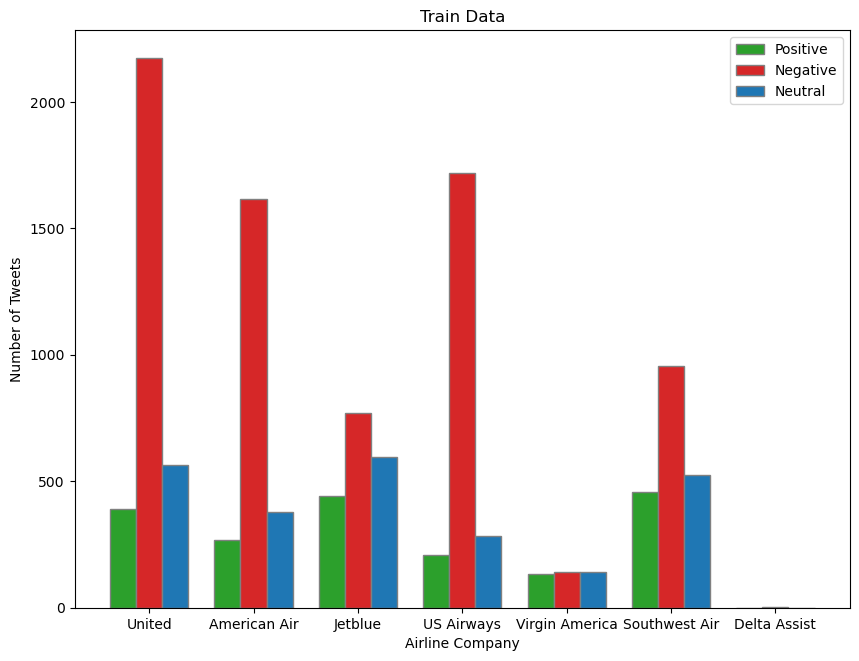

In [ ]:
# set figure size
plt.rcParams["figure.figsize"] = (10,7.5)

# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(train_barchart_data['Positive']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# plot the barcharts
plt.bar(br1, train_barchart_data['Positive'], color ='tab:green', width=0.25, edgecolor ='grey', label='Positive')
plt.bar(br2, train_barchart_data['Negative'], color ='tab:red', width=0.25, edgecolor ='grey', label='Negative')
plt.bar(br3, train_barchart_data['Neutral'], color ='tab:blue', width=0.25, edgecolor ='grey', label='Neutral')

# Adding Labels
plt.title('Train Data')
plt.xlabel('Airline Company')
plt.ylabel('Number of Tweets')
plt.xticks([r + barWidth for r in range(len(train_barchart_data['Positive']))],
        ['United','American Air','Jetblue','US Airways','Virgin America','Southwest Air','Delta Assist'])
plt.legend()
plt.savefig('train-barchart.png')

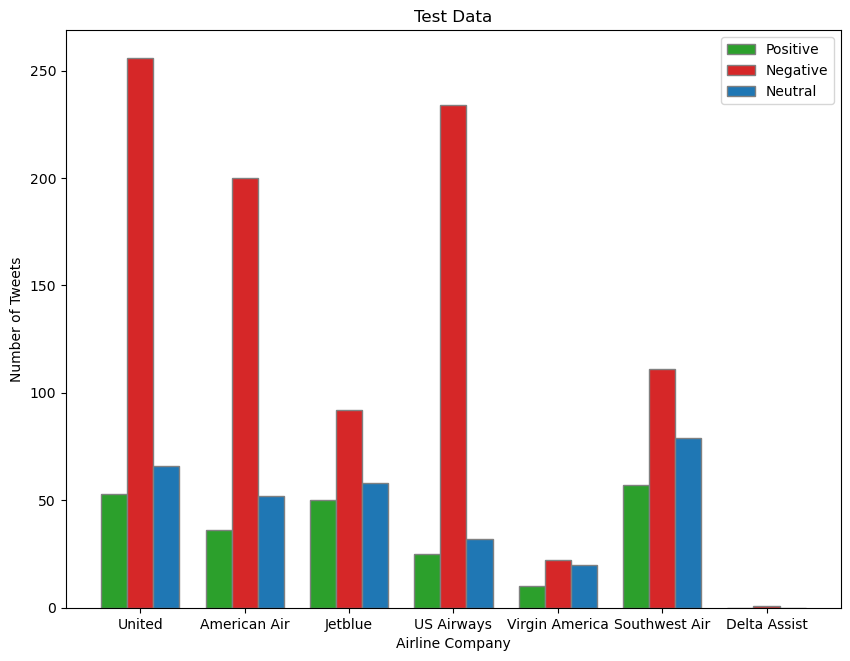

In [ ]:
# set figure size
plt.rcParams["figure.figsize"] = (10,7.5)

# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(test_barchart_data['Positive']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# plot the barcharts
plt.bar(br1, test_barchart_data['Positive'], color ='tab:green', width=0.25, edgecolor ='grey', label='Positive')
plt.bar(br2, test_barchart_data['Negative'], color ='tab:red', width=0.25, edgecolor ='grey', label='Negative')
plt.bar(br3, test_barchart_data['Neutral'], color ='tab:blue', width=0.25, edgecolor ='grey', label='Neutral')

# Adding Labels
plt.title('Test Data')
plt.xlabel('Airline Company')
plt.ylabel('Number of Tweets')
plt.xticks([r + barWidth for r in range(len(test_barchart_data['Positive']))],
        ['United','American Air','Jetblue','US Airways','Virgin America','Southwest Air','Delta Assist'])
plt.legend()
plt.savefig('test-barchart.png')

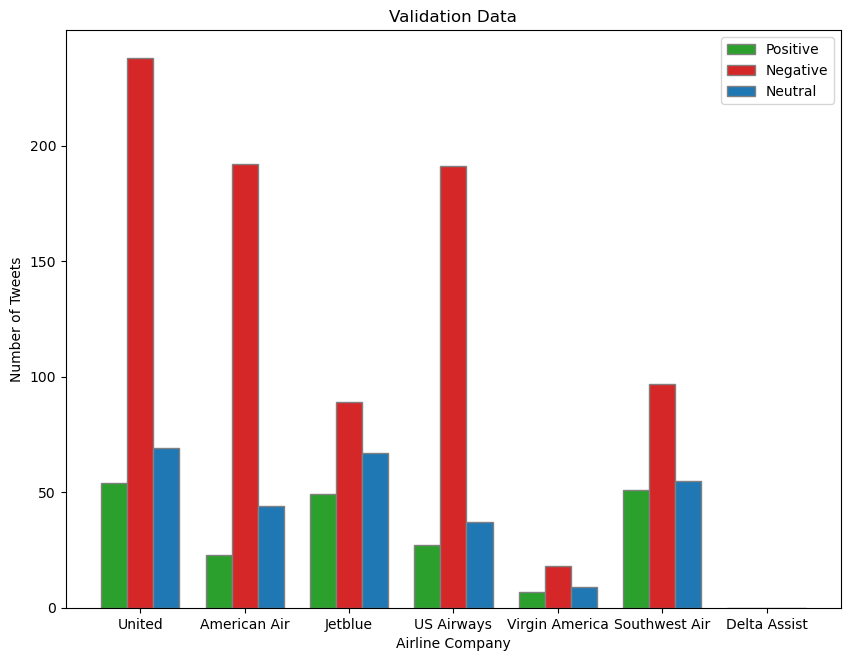

In [ ]:
# set figure size
plt.rcParams["figure.figsize"] = (10,7.5)

# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(dev_barchart_data['Positive']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# plot the barcharts
plt.bar(br1, dev_barchart_data['Positive'], color ='tab:green', width=0.25, edgecolor ='grey', label='Positive')
plt.bar(br2, dev_barchart_data['Negative'], color ='tab:red', width=0.25, edgecolor ='grey', label='Negative')
plt.bar(br3, dev_barchart_data['Neutral'], color ='tab:blue', width=0.25, edgecolor ='grey', label='Neutral')

# Adding Labels
plt.title('Validation Data')
plt.xlabel('Airline Company')
plt.ylabel('Number of Tweets')
plt.xticks([r + barWidth for r in range(len(dev_barchart_data['Positive']))],
        ['United','American Air','Jetblue','US Airways','Virgin America','Southwest Air','Delta Assist'])
plt.legend()
plt.savefig('dev-barchart.png')

# Data Preprocessing:
1. Convert to lower case
2. Remove hyperlinks
3. Convert html to string
4. Converting contracted words to full
5. Remove all punctuations
6. Remove stop words
7. Remove Numbers
8. Split data into X and Y
9. Tokenizing
10. Lemmatizating
11. Stemming

## Functions for Data Pre-processing

1-5. Data Pre-processing

In [ ]:
def preprocess(dataset):
  for i in range(len(dataset)):
    lowercase = dataset['text'][i].lower() # convert tweet to lower case
    dataset.insert(1,"text_lower", lowercase)
    dataset.at[i,"text_lower"]= re.sub(r'http\S+', '', dataset.at[i,"text_lower"]) # remove hyperlinks
    dataset.at[i,"text_lower"] = html.unescape(dataset.at[i,"text_lower"]) # convert html entities to string
    dataset.at[i,"text_lower"] = contractions.fix(dataset.at[i,"text_lower"])  # convert contractions to full
    dataset.at[i,"text_lower"] = re.sub(r"[^\w\s]",'', dataset.at[i,"text_lower"]) # remove punctuations
    dataset.at[i,"text_lower"] = re.sub(r'\d', '', dataset.at[i,"text_lower"]) # remove numbers
  return dataset

7. Data Pre-processing: Removing Stopwords

In [ ]:
def remove_stopwords(dataset):
    stop_words = set(stopwords.words('english'))
    for i in range(len(dataset)):
        filtered_sentence=[]
        word_tokens = word_tokenize(dataset.at[i,'text_lower'])
        for word in word_tokens:
            if word not in stop_words:
                filtered_sentence.append(word)
            joined_sentence = " ".join(w for w in filtered_sentence)
            dataset.at[i,'text_lower'] = joined_sentence
    return dataset

8. Data Pre-processing: split data into X and Y

In [ ]:
def split_X_Y(dataset):
    X = dataset['text_lower']
    Y = dataset['airline_sentiment']
    return X, Y

9. Data Pre-processing: Tokenizing

In [ ]:
# creating a function to tokenize tweets of a dataset
def tokenize_tweet(dataset):
    tokenizer = TweetTokenizer()
    tokens_data = ['None'] * len(dataset)
    for i in range(len(dataset)):
        tokens = tokenizer.tokenize(dataset[i])
        tokens_data[i] = tokens
    return tokens_data

10. Data Pre-processing: Lemmatization

In [ ]:
# creating a function to lemmatize a tokenized tweet
def lemmatize_tweet(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('J'):
            pos = 'a'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'n'
        lemmatized_tweet.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_tweet

In [ ]:
# creating a function to lemmatize all tweets in a dataset
def lemmatize_data(dataset):
    data_lemmatize = ['None'] * len(dataset)
    for i in range(len(dataset)):
        lemmatize_sentence = ''
        lemmatized = lemmatize_tweet(dataset[i])
        for word in lemmatized:
            lemmatize_sentence =  " ".join([lemmatize_sentence, word])
        data_lemmatize[i] = lemmatize_sentence
    return data_lemmatize

11. Data Pre-processing: Stemming

In [ ]:
# creating a funtion to stem a tweet
def stem_tweet(tokens, method="Porter"):
    stem_tweet = []
    if method == "Porter":
        PS = PorterStemmer()
        for word in tokens:
            stem_tweet.append(PS.stem(word))
    elif method == "Lancaster":
        LS = LancasterStemmer()
        for word in tokens:
            stem_tweet.append(LS.stem(word))
    return stem_tweet

In [ ]:
# creating a function to stem a whole dataset
def stem_data(dataset, method="Porter"):
    data_stemming = ['None'] * len(dataset)
    for i in range(len(dataset)):
        stem_sentence = ''
        stemming = stem_tweet(dataset[i], method)
        for word in stemming:
            stem_sentence = " ".join([stem_sentence, word])
            data_stemming[i] = stem_sentence
    return data_stemming

## Representing text in Numeric form:

1. Bag of Words
2. Tf-Idf

1. Representing text in Numeric form: Bag of Words

In [ ]:
# creating a function to create a BOW vectorizer, fit on training data and transform train, test and dev data
def BOW_vectorizer(training, testing, validation):
    # creating a BOW vectorizer and specify how we want to break up the words
    vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', lowercase=False)

    # fitting the vectorizer to the training data to get Bag of Words
    BagOfWords = vectorizer.fit_transform(training)

    # transforming training and testing data into vectors for BOW
    train_inputs = vectorizer.transform(training)
    test_inputs = vectorizer.transform(testing)
    dev_inputs = vectorizer.transform(validation)

    # vocabulary
    vocabulary = vectorizer.get_feature_names_out()

    return train_inputs, test_inputs, dev_inputs, BagOfWords, vocabulary

2. Representing text in numeric form: Tf-Idf

In [ ]:
# creating a function to create a tf-idf vectorizer, fit on training data and transform train, test and dev data
def TfIdf_vectorizer(training, testing, validation, num_features=2500):
    # creating a BOW vectorizer and specify how we want to break up the words
    vectorizer = TfidfVectorizer(max_features=num_features, stop_words=stopwords.words('english'))

    # fitting the vectorizer to the training data to get Bag of Words
    tfid = vectorizer.fit_transform(training).toarray()

    # transforming training and testing data into vectors for BOW
    train_inputs = vectorizer.transform(training).toarray()
    test_inputs = vectorizer.transform(testing).toarray()
    dev_inputs = vectorizer.transform(validation).toarray()

    return train_inputs, test_inputs, dev_inputs

Modelling:
1. Naives Bayes Classifier
2. Gaussian Bayes Classifier
3. Random Forest Classifier
4. Recurrent Neural Networks (LSTM)
5. Recurrent Neural Networks (Bi-LSTM)

# 1. Modelling: Naives Bayes Classifier

## 1.1 Model: Naives Bayes Classifier  
Normalisation: N/A (Original)  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_BOW, test_X_BOW, dev_X_BOW, BOW, words = BOW_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_Tuning_BOW, train_dev_X_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_BOW, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.1}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.1)

In [ ]:
# training Naives Bayes Classifier with original training data with BOW
NBC_BOW = nb.fit(train_X_BOW, train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_BOW.predict(test_X_BOW)

# calculating accuracy score, f1-score, confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:",accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7800687285223368
The f-1 score is :
 [0.86687631 0.55855856 0.68456376]
Confusion Matrix:
 [[827  63  24]
 [116 155  38]
 [ 51  28 153]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_BOW.predict(train_X_BOW)

# calculating accuracy score, f1-score, confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:",accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.9031188918160958
The f-1 score is :
 [0.93643473 0.80699536 0.89208257]
Confusion Matrix:
 [[7005  270  102]
 [ 457 1915  119]
 [ 122   70 1707]]


In [ ]:
# predicting airline_sentiment for validation data
y_predict_dev= NBC_BOW.predict(dev_X_BOW)

# calculating accuracy score, f1-score, confusion matrix for validation data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:",accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7615793470007594
The f-1 score is :
 [0.85221392 0.51219512 0.67493797]
Confusion Matrix:
 [[741  60  24]
 [123 126  30]
 [ 50  27 136]]


## 1.2 Model: Naives Bayes Classifier  
Normalisation: Lemmatization  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)

# Bag of Words with lemmatize training X data
train_X_lemmatize_BOW, test_X_lemmatize_BOW, dev_X_lemmatize_BOW, BOW_lemmatize, words_lemmatize = BOW_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with lemmatize training X data
train_tuning, train_dev_X_lemmatize_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_lemmatize_BOW, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 1}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=1)

In [ ]:
# training Naives Bayes Classifier with lemmatize training data with BOW
NBC_BOW = nb.fit(train_X_lemmatize_BOW,train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_BOW.predict(test_X_lemmatize_BOW)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7663230240549829
The f-1 score is :
 [0.85574092 0.5186722  0.60512821]
Confusion Matrix:
 [[872  28  14]
 [158 125  26]
 [ 94  20 118]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_BOW.predict(train_X_lemmatize_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8404861052094842
The f-1 score is :
 [0.8946377  0.67305849 0.79278231]
Confusion Matrix:
 [[7124  187   66]
 [ 978 1404  109]
 [ 447   90 1362]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_BOW.predict(dev_X_lemmatize_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

## 1.3 Model: Naives Bayes Classifier  
Normalisation: Porter Stemming   
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Bag of Words with Porter stemming training X data
train_X_PS_BOW, test_X_PS_BOW, dev_X_PS_BOW, BOW_PS, words_PS = BOW_vectorizer(train_X_PS, test_X_PS, dev_X_PS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with Porter stemming training X data
train_tuning, train_dev_X_PS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_PS_BOW, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.1}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.1)

In [ ]:
# training Naives Bayes Classifier with Porter stemming training data with BOW
NBC_BOW = nb.fit(train_X_PS_BOW, train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_BOW.predict(test_X_PS_BOW)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.770446735395189
The f-1 score is :
 [0.86132915 0.55062167 0.6559633 ]
Confusion Matrix:
 [[823  70  21]
 [114 155  40]
 [ 60  29 143]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_BOW.predict(train_X_PS_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8864621398827228
The f-1 score is :
 [0.92534525 0.77474041 0.87192891]
Confusion Matrix:
 [[6935  315  127]
 [ 531 1828  132]
 [ 146   85 1668]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_BOW.predict(dev_X_PS_BOW)

# calculating accuracy score, f1-score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7585421412300684
The f-1 score is :
 [0.85304248 0.50612245 0.65671642]
Confusion Matrix:
 [[743  59  23]
 [121 124  34]
 [ 53  28 132]]


## 1.4 Model: Naives Bayes Classifier  
Normalisation: Lancaster Stemming  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_BOW, test_X_LS_BOW, dev_X_LS_BOW, BOW_LS, words_LS = BOW_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with Lancaster stemming training X data
train_tuning, train_dev_X_LS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_LS_BOW, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 1}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=1)

In [ ]:
# training Naives Bayes Classifier with Lancaster stemming training data with BOW
NBC_BOW = nb.fit(train_X_LS_BOW, train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_BOW.predict(test_X_LS_BOW)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7601374570446735
The f-1 score is :
 [0.85588235 0.49579832 0.58375635]
Confusion Matrix:
 [[873  29  12]
 [156 118  35]
 [ 97  20 115]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_BOW.predict(train_X_LS_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8357270332285205
The f-1 score is :
 [0.89160113 0.65657294 0.7947096 ]
Confusion Matrix:
 [[7086  212   79]
 [1007 1366  118]
 [ 425   92 1382]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_BOW.predict(dev_X_LS_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7593014426727411
The f-1 score is :
 [0.85281385 0.48387097 0.60795455]
Confusion Matrix:
 [[788  29   8]
 [150 105  24]
 [ 85  21 107]]


## 1.5 Model: Naives Bayes Classifier  
Normalisation: N/A (Original)  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_TfIdf, test_X_TfIdf, dev_X_TfIdf = TfIdf_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_tuning, train_dev_X_TfIdf, dev_tuning = TfIdf_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_TfIdf, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.1}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.1)

In [ ]:
# training Naives Bayes Classifier with original training data with TF-IDF
NBC_TFID = nb.fit(train_X_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_TFID.predict(test_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7690721649484537
The f-1 score is :
 [0.85994123 0.47478992 0.65306122]
Confusion Matrix:
 [[878  31   5]
 [169 113  27]
 [ 81  23 128]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_TFID.predict(train_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8173706127305176
The f-1 score is :
 [0.88312488 0.60420842 0.75203866]
Confusion Matrix:
 [[7167  167   43]
 [1161 1206  124]
 [ 526  128 1245]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_TFID.predict(dev_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7441154138192863
The f-1 score is :
 [0.8408728  0.43478261 0.58651026]
Confusion Matrix:
 [[790  24  11]
 [172  90  17]
 [ 92  21 100]]


## 1.6 Model: Naives Bayes Classifier  
Normalisation: Lemmatization  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy())
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)

# Tf-Idf with lemmatize training X data
train_X_lemmatize_TfIdf, test_X_lemmatize_TfIdf, dev_X_lemmatize_TfIdf = TfIdf_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with lemmatize training X data
train_tuning, train_dev_X_lemmatize_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_lemmatize_TfIdf, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.01}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.01)

In [ ]:
# training Naives Bayes Classifier with lemmatize training data with TF-IDF
NBC_TFID = nb.fit(train_X_lemmatize_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_TFID.predict(test_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7670103092783506
The f-1 score is :
 [0.85964912 0.48851775 0.61741425]
Confusion Matrix:
 [[882  28   4]
 [166 117  26]
 [ 90  25 117]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_TFID.predict(train_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8175405795869806
The f-1 score is :
 [0.88250524 0.60475594 0.75610491]
Confusion Matrix:
 [[7158  174   45]
 [1164 1208  119]
 [ 523  122 1254]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_TFID.predict(dev_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7456340167046317
The f-1 score is :
 [0.8452508  0.43764706 0.57910448]
Confusion Matrix:
 [[792  27   6]
 [167  93  19]
 [ 90  26  97]]


## 1.7 Model: Naives Bayes Classifier  
Normalisation: Porter Stemming  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Tf-Idf with porter stemming training X data
train_X_PS_TfIdf, test_X_PS_TfIdf, dev_X_PS_TfIdf = TfIdf_vectorizer(train_X_PS, test_X_PS, dev_X_PS)


In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with porter stemming training X data
train_tuning, train_dev_X_PS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_PS_TfIdf, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.01}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.01)

In [ ]:
# training Naives Bayes Classifier with Porter stemming training data with TF-IDF
NBC_TFID = nb.fit(train_X_PS_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_TFID.predict(test_X_PS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7608247422680412
The f-1 score is :
 [0.85534591 0.48625793 0.58378378]
Confusion Matrix:
 [[884  27   3]
 [167 115  27]
 [102  22 108]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_TFID.predict(train_X_PS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8172006458740546
The f-1 score is :
 [0.88281635 0.6122449  0.74296206]
Confusion Matrix:
 [[7172  163   42]
 [1148 1230  113]
 [ 551  134 1214]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_TFID.predict(dev_X_PS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.741837509491268
The f-1 score is :
 [0.84115139 0.43230404 0.57566766]
Confusion Matrix:
 [[789  29   7]
 [168  91  20]
 [ 94  22  97]]


## 1.8 Model: Naives Bayes Classifier  
Normalisation: Lancaster Stemming  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = remove_punctuations(train_amended)
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_TfIdf, test_X_LS_TfIdf, dev_X_LS_TfIdf = TfIdf_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with porter stemming training X data
train_tuning, train_dev_X_LS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create the param grid
param_grid = {'alpha': alpha}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
NB_GridSearch = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
NB_GridSearch.fit(train_dev_X_LS_TfIdf, train_dev_Y)

# get the best parameters
NB_GridSearch.best_params_

Fitting 1 folds for each of 7 candidates, totalling 7 fits


{'alpha': 0.01}

In [ ]:
# define model with best parameters
nb = MultinomialNB(alpha=0.01)

In [ ]:
# training Naives Bayes Classifier with Lancaster stemming training data with TF-IDF
NBC_TFID = nb.fit(train_X_LS_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = NBC_TFID.predict(test_X_LS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7608247422680412
The f-1 score is :
 [0.85838569 0.47659574 0.57681941]
Confusion Matrix:
 [[888  22   4]
 [169 112  28]
 [ 98  27 107]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = NBC_TFID.predict(train_X_LS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8150760601682672
The f-1 score is :
 [0.88132678 0.59984852 0.74643183]
Confusion Matrix:
 [[7174  157   46]
 [1184 1188  119]
 [ 545  125 1229]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = NBC_TFID.predict(dev_X_LS_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.738800303720577
The f-1 score is :
 [0.83898305 0.44180523 0.54153846]
Confusion Matrix:
 [[792  28   5]
 [167  93  19]
 [104  21  88]]


# 2. Modelling: Gaussian Naive Bayes Classifier

## 2.1 Model: Gaussian Naives Bayes Classifier  
Normalisation: N/A (Original)  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_BOW, test_X_BOW, dev_X_BOW, BOW, words = BOW_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_tuning, train_dev_X_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_BOW.toarray(), train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with original training data with BOW
GNBC_BOW = gnb.fit(train_X_BOW.toarray(),train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_BOW.predict(test_X_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.554639175257732
The f-1 score is :
 [0.64197531 0.48600884 0.46838407]
Confusion Matrix:
 [[442 180 292]
 [ 14 165 130]
 [  7  25 200]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_BOW.predict(train_X_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6400101980113878
The f-1 score is :
 [0.69672562 0.62005085 0.55858311]
Confusion Matrix:
 [[3979 1266 2132]
 [  54 1707  730]
 [  12   42 1845]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_BOW.predict(dev_X_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5451784358390281
The f-1 score is :
 [0.63716814 0.44371941 0.4781491 ]
Confusion Matrix:
 [[396 179 250]
 [ 14 136 129]
 [  8  19 186]]


## 2.2 Model: Gaussian Naives Bayes Classifier  
Normalisation:Lemmatization  
Convert to numeric method: Bag of Words

In [ ]:
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)


# Bag of Words with lemmatize training X data
train_X_lemmatize_BOW, test_X_lemmatize_BOW, dev_X_lemmatize_BOW, BOW_lemmatize, words_lemmatize = BOW_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with lemmatize training X data
train_tuning, train_dev_X_lemmatize_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_lemmatize_BOW.toarray(), train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with lemmatize training data with BOW
GNBC_BOW = gnb.fit(train_X_lemmatize_BOW.toarray(),train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_BOW.predict(test_X_lemmatize_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for test
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5608247422680412
The f-1 score is :
 [0.65569077 0.47181009 0.47437426]
Confusion Matrix:
 [[458 182 274]
 [ 16 159 134]
 [  9  24 199]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_BOW.predict(train_X_lemmatize_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6455341208464349
The f-1 score is :
 [0.71580756 0.60309084 0.55555556]
Confusion Matrix:
 [[4166 1168 2043]
 [  75 1600  816]
 [  22   47 1830]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_BOW.predict(dev_X_lemmatize_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for dev
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5596051632498101
The f-1 score is :
 [0.66352201 0.44333333 0.47769029]
Confusion Matrix:
 [[422 165 238]
 [ 17 133 129]
 [  8  23 182]]


## 2.3 Model: Gaussian Naives Bayes Classifier  
Normalisation: Porter Stemming  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Bag of Words with Porter stemming training X data
train_X_PS_BOW, test_X_PS_BOW, dev_X_PS_BOW, BOW_PS, words_PS = BOW_vectorizer(train_X_PS, test_X_PS, dev_X_PS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with Porter stemming training X data
train_tuning, train_dev_X_PS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_PS_BOW.toarray(), train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with Porter stemming training data with BOW
GNBC_BOW = gnb.fit(train_X_PS_BOW.toarray(),train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_BOW.predict(test_X_PS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5896907216494846
The f-1 score is :
 [0.69751381 0.48742138 0.47941889]
Confusion Matrix:
 [[505 147 262]
 [ 20 155 134]
 [  9  25 198]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_BOW.predict(train_X_PS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6531826293872695
The f-1 score is :
 [0.73049225 0.60011563 0.55579334]
Confusion Matrix:
 [[4311 1087 1979]
 [  88 1557  846]
 [  27   54 1818]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_BOW.predict(dev_X_PS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5732725892179195
The f-1 score is :
 [0.6769468  0.45183888 0.48825065]
Confusion Matrix:
 [[439 146 240]
 [ 24 129 126]
 [  9  17 187]]


## 2.4 Model: Gaussian Naives Bayes Classifier  
Normalisation: Lancaster Stemming  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_BOW, test_X_LS_BOW, dev_X_LS_BOW, BOW_LS, words_LS = BOW_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with Lancaster stemming training X data
train_tuning, train_dev_X_LS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_LS_BOW.toarray(), train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with Lancaster stemming training data with BOW
GNBC_BOW = gnb.fit(train_X_LS_BOW.toarray(),train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_BOW.predict(test_X_LS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5807560137457045
The f-1 score is :
 [0.69390582 0.4778481  0.46282974]
Confusion Matrix:
 [[501 142 271]
 [ 20 151 138]
 [  9  30 193]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_BOW.predict(train_X_LS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6526727288178805
The f-1 score is :
 [0.73334458 0.59208996 0.55385087]
Confusion Matrix:
 [[4348 1079 1950]
 [ 100 1527  864]
 [  33   61 1805]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_BOW.predict(dev_X_LS_BOW.toarray())

# calculating accuracy score, f1-score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.577828397873956
The f-1 score is :
 [0.68509985 0.45104895 0.48947368]
Confusion Matrix:
 [[446 144 235]
 [ 24 129 126]
 [  7  20 186]]


## 2.5 Model: Gaussian Naives Bayes Classifier  
Normalisation: N/A (Original)  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_TfIdf, test_X_TfIdf, dev_X_TfIdf = TfIdf_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_tuning, train_dev_X_TfIdf, dev_tuning = TfIdf_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_TfIdf, train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with original training data with TF-IDF
GNBC_TFID = gnb.fit(train_X_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_TFID.predict(test_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6185567010309279
The f-1 score is :
 [0.74116891 0.45348837 0.50225564]
Confusion Matrix:
 [[577 180 157]
 [ 44 156 109]
 [ 22  43 167]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_TFID.predict(train_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7242287753887992
The f-1 score is :
 [0.79560124 0.62823276 0.65755953]
Confusion Matrix:
 [[4992 1237 1148]
 [ 153 1749  589]
 [  27   91 1781]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_TFID.predict(dev_X_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6195899772209568
The f-1 score is :
 [0.73205402 0.46869984 0.51324503]
Confusion Matrix:
 [[515 159 151]
 [ 48 146  85]
 [ 19  39 155]]


## 2.6 Model: Gaussian Naives Bayes Classifier  
Normalisation: Lemmatization    
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)

# Tf-Idf with lemmatize training X data
train_X_lemmatize_TfIdf, test_X_lemmatize_TfIdf, dev_X_lemmatize_TfIdf = TfIdf_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with lemmatize training X data
train_tuning, train_dev_X_lemmatize_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_lemmatize_TfIdf, train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.1}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.1)

In [ ]:
# training Gaussian Naive Bayes with lemmatize training data with TF-IDF
GNBC_TFID = gnb.fit(train_X_lemmatize_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_TFID.predict(test_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6116838487972509
The f-1 score is :
 [0.72074468 0.48188976 0.50583658]
Confusion Matrix:
 [[542 145 227]
 [ 39 153 117]
 [  9  28 195]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_TFID.predict(train_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6891306195291919
The f-1 score is :
 [0.76428455 0.63341743 0.58474159]
Confusion Matrix:
 [[4695  941 1741]
 [ 186 1632  673]
 [  28   89 1782]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_TFID.predict(dev_X_lemmatize_TfIdf)

# calculating accuracy score, f1-score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6119969627942293
The f-1 score is :
 [0.72087912 0.47818499 0.50862069]
Confusion Matrix:
 [[492 132 201]
 [ 37 137 105]
 [ 11  25 177]]


## 2.7 Model: Gaussian Naives Bayes Classifier  
Normalisation: Porter Stemming  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Bag of Words with Porter stemming training X data
train_X_PS_TfIdf, test_X_PS_TfIdf, dev_X_PS_TfIdf = TfIdf_vectorizer(train_X_PS, test_X_PS, dev_X_PS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with Porter Stemming training X data
train_tuning, train_dev_X_PS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_PS_TfIdf, train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.01}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.01)

In [ ]:
# training Gaussian Naive Bayes with Porter Stemming training data with TF-IDF
GNBC_TFID = gnb.fit(train_X_PS_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_TFID.predict(test_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6261168384879725
The f-1 score is :
 [0.75382653 0.46504559 0.48830409]
Confusion Matrix:
 [[591 155 168]
 [ 39 153 117]
 [ 24  41 167]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_TFID.predict(train_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7215942891136229
The f-1 score is :
 [0.7967454  0.62924282 0.63885362]
Confusion Matrix:
 [[5043 1083 1251]
 [ 202 1687  602]
 [  37  101 1761]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_TFID.predict(dev_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.5998481397114654
The f-1 score is :
 [0.71650212 0.43389831 0.49201278]
Confusion Matrix:
 [[508 149 168]
 [ 60 128  91]
 [ 25  34 154]]


## 2.8 Model: Gaussian Naives Bayes Classifier  
Normalisation: Lancaster Stemming  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_TfIdf, test_X_LS_TfIdf, dev_X_LS_TfIdf = TfIdf_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with Lancaster Stemming training X data
train_tuning, train_dev_X_LS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with GridSearch
# define parameter grid
smoothing = np.logspace(0,-9, num=10)

# Create the param grid
param_grid = {'var_smoothing': smoothing}

# fitting the GridSearch
GNB_GridSearch = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=ps, verbose=2, n_jobs=4)
GNB_GridSearch.fit(train_dev_X_LS_TfIdf, train_dev_Y)

# get the best parameters
GNB_GridSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'var_smoothing': 0.1}

In [ ]:
# define model with best parameters
gnb = GaussianNB(var_smoothing=0.1)

In [ ]:
# training Gaussian Naive Bayes with Lancaster Stemming training data with TF-IDF
GNBC_TFID = gnb.fit(train_X_LS_TfIdf,train_Y)

# predicting airline_sentiment for test data
y_predict = GNBC_TFID.predict(test_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6171821305841925
The f-1 score is :
 [0.72679045 0.50897227 0.49176172]
Confusion Matrix:
 [[548 119 247]
 [ 37 156 116]
 [  9  29 194]]


In [ ]:
# predicting airline_sentiment for train data
y_predict_train = GNBC_TFID.predict(train_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6757032378686156
The f-1 score is :
 [0.75833945 0.61841838 0.56059175]
Confusion Matrix:
 [[4649  818 1910]
 [ 206 1521  764]
 [  29   89 1781]]


In [ ]:
# predicting airline_sentiment for dev data
y_predict_dev = GNBC_TFID.predict(dev_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6135155656795748
The f-1 score is :
 [0.71970803 0.48638838 0.50771388]
Confusion Matrix:
 [[493 117 215]
 [ 41 134 104]
 [ 11  21 181]]


# 3. Modelling: Random Forest Classifier

## 3.1 Model: Random Forest Classifier  
Normalisation: N/A (Original)  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_BOW, test_X_BOW, dev_X_BOW, BOW, words = BOW_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with original training X data (i.e., no tokenising, lemmatization or stemming)
train_Tuning_BOW, train_dev_X_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = np.arange(2, 10, step=1)

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2, 10, step=1)

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap': ['True', 'False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_BOW, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 33,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 76,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=33, min_samples_split=6, min_samples_leaf=3,
                             max_features='sqrt', max_depth=76, criterion='entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with original training data with BOW
RFC_BOW = RFC.fit(train_X_BOW, train_Y)

# generating predictions on test data
y_predict = RFC_BOW.predict(test_X_BOW)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7120274914089347
The f-1 score is :
 [0.82069905 0.23822715 0.51445087]
Confusion Matrix:
 [[904   5   5]
 [246  43  20]
 [139   4  89]]


In [ ]:
# generating predictions on train data
y_prediction_train = RFC_BOW.predict(train_X_BOW)

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y, y_prediction_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_prediction_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_prediction_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7221891731112433
The f-1 score is :
 [0.82388127 0.28371628 0.54946619]
Confusion Matrix:
 [[7300   43   34]
 [1960  426  105]
 [1084   43  772]]


In [ ]:
# generating predictions on dev data
y_prediction_dev = RFC_BOW.predict(dev_X_BOW)

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y, y_prediction_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_prediction_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_prediction_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7000759301442673
The f-1 score is :
 [0.808933   0.18412698 0.51315789]
Confusion Matrix:
 [[815   3   7]
 [244  29   6]
 [131   4  78]]


## 3.2 Model: Random Forest Classifier  
Normalisation: Lemmatization  
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)

# Bag of Words with lemmatize training X data
train_X_lemmatize_BOW, test_X_lemmatize_BOW, dev_X_lemmatize_BOW, BOW_lemmatize, words_lemmatize = BOW_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with lemmatize training X data
train_Tuning_BOW, train_dev_X_lemmatize_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap': ['True','False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_lemmatize_BOW, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 98,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=41, min_samples_split=10, min_samples_leaf=1, max_features= 'auto',
                             max_depth=98, criterion= 'entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with lemmatized training data with BOW
RFC_BOW = RFC.fit(train_X_lemmatize_BOW, train_Y)

# generating predictions on test data
y_predict = RFC_BOW.predict(test_X_lemmatize_BOW)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7443298969072165
The f-1 score is :
 [0.84582339 0.40186916 0.57364341]
Confusion Matrix:
 [[886  15  13]
 [192  86  31]
 [103  18 111]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_BOW.predict(train_X_lemmatize_BOW)

# calculating accuracy score and confusion matrix for train test
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8823829353276111
The f-1 score is :
 [0.92058102 0.74075852 0.87734488]
Confusion Matrix:
 [[7320   54    3]
 [ 905 1543   43]
 [ 301   78 1520]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_BOW.predict(dev_X_lemmatize_BOW)

# calculating accuracy score and confusion matrix for dev test
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.6879271070615034
The f-1 score is :
 [0.80413386 0.18238994 0.42253521]
Confusion Matrix:
 [[817   3   5]
 [244  29   6]
 [146   7  60]]


## 3.3 Model: Random Forest Classifier  
Normalisation: Porter Stemming   
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Bag of Words with Porter stemming training X data
train_X_PS_BOW, test_X_PS_BOW, dev_X_PS_BOW, BOW_PS, words_PS = BOW_vectorizer(train_X_PS, test_X_PS, dev_X_PS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with porter stemming training X data
train_Tuning_BOW, train_dev_X_PS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
            'bootstrap': ['True','False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_PS_BOW, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 98,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=41, min_samples_split=10, min_samples_leaf=1, max_features='auto',
                             max_depth=98, criterion='entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with Porter Stemmer training data with BOW
RFC_BOW = RFC.fit(train_X_PS_BOW, train_Y)

# generating predictions on test data
y_predict = RFC_BOW.predict(test_X_PS_BOW)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7539518900343642
The f-1 score is :
 [0.85077519 0.44742729 0.59649123]
Confusion Matrix:
 [[878  21  15]
 [176 100  33]
 [ 96  17 119]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_BOW.predict(train_X_PS_BOW)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8857822724568709
The f-1 score is :
 [0.92587908 0.75247992 0.86582569]
Confusion Matrix:
 [[7320   50    7]
 [ 826 1593   72]
 [ 289  100 1510]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_BOW.predict(dev_X_PS_BOW)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7532270311313591
The f-1 score is :
 [0.84493671 0.4        0.64589235]
Confusion Matrix:
 [[801  15   9]
 [185  77  17]
 [ 85  14 114]]


## 3.4 Model: Random Forest Classifier  
Normalisation: Lancaster Stemming   
Convert to numeric method: Bag of Words

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_BOW, test_X_LS_BOW, dev_X_LS_BOW, BOW_LS, words_LS = BOW_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Bag of Words with Lancaster stemming training X data
train_Tuning_BOW, train_dev_X_LS_BOW, dev_tuning, BOW_tuning, words_tuning = BOW_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap': ['True','False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_LS_BOW, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 98,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC= RandomForestClassifier(n_estimators=41, min_samples_split=10, min_samples_leaf=1, max_features='auto',
                            max_depth=98, criterion='entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with Lancaster Stemmer training data with BOW
RFC_BOW = RFC.fit(train_X_LS_BOW, train_Y)

# generating predictions on test data
y_predict = RFC_BOW.predict(test_X_LS_BOW)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7560137457044673
The f-1 score is :
 [0.85188771 0.45614035 0.59793814]
Confusion Matrix:
 [[880  22  12]
 [177 104  28]
 [ 95  21 116]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_BOW.predict(train_X_LS_BOW)

# calculating accuracy score, f1-score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.8904563610096031
The f-1 score is :
 [0.92852151 0.76366184 0.87446627]
Confusion Matrix:
 [[7307   61    9]
 [ 787 1635   69]
 [ 268   95 1536]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_BOW.predict(dev_X_LS_BOW)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7395596051632498
The f-1 score is :
 [0.83796539 0.35170604 0.62427746]
Confusion Matrix:
 [[799  16  10]
 [197  67  15]
 [ 86  19 108]]


## 3.5 Model: Random Forest Classifier  
Normalisation: N/A (Original)   
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_X_TfIdf, test_X_TfIdf, dev_X_TfIdf = TfIdf_vectorizer(train_X, test_X, dev_X)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with original training X data (i.e., no tokenising, lemmatization or stemming)
train_tuning, train_dev_X_TfIdf, dev_tuning = TfIdf_vectorizer(train_X, train_dev_X, dev_X)

In [ ]:
# hyperparameter tuning with randomizedsearcht

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap':['True', 'False']}

# define validation split
from sklearn.model_selection import PredefinedSplit # index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_TfIdf, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 98,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=41, min_samples_split=10, min_samples_leaf=1, max_features='auto',
                                  max_depth=98, criterion='entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with original training data with Tf-Idf
RFC_TfIdf = RFC.fit(train_X_TfIdf, train_Y)

# generating predictions on test data
y_predict = RFC_TfIdf.predict(test_X_TfIdf)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7505154639175258
The f-1 score is :
 [0.84672252 0.45243129 0.61764706]
Confusion Matrix:
 [[859  36  19]
 [171 107  31]
 [ 85  21 126]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_TfIdf.predict(train_X_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.908132914081754
The f-1 score is :
 [0.9384338  0.80224972 0.90817186]
Confusion Matrix:
 [[7286   85    6]
 [ 669 1783   39]
 [ 196   86 1617]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_TfIdf.predict(dev_X_TfIdf)

# calculating accuracy score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.741837509491268
The f-1 score is :
 [0.83967828 0.39512195 0.62952646]
Confusion Matrix:
 [[783  26  16]
 [181  81  17]
 [ 76  24 113]]


## 3.6 Model: Random Forest Classifier  
Normalisation: Lemmatization  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)

# Tf-Idf with lemmatize training X data
train_X_lemmatize_TfIdf, test_X_lemmatize_TfIdf, dev_X_lemmatize_TfIdf = TfIdf_vectorizer(train_X_lemmatize, test_X_lemmatize, dev_X_lemmatize)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_lemmatize = lemmatize_data(train_dev_X_token)

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with lemmatized training X data
train_tuning, train_dev_X_lemmatize_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_lemmatize, train_dev_X_lemmatize, dev_X_lemmatize)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap':['True','False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_TfIdf, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 17,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 87,
 'criterion': 'gini',
 'bootstrap': 'False'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=17, min_samples_split=5, min_samples_leaf=4, max_features='auto',
                             max_depth=87, criterion='gini', bootstrap=False, random_state=0)

In [ ]:
# training Random Forest Classifier with lemmatize training data with Tf-Idf
RFC_TfIdf = RFC.fit(train_X_lemmatize_TfIdf, train_Y)

# generating predictions on test data
y_predict = RFC_TfIdf.predict(test_X_lemmatize_TfIdf)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7484536082474227
The f-1 score is :
 [0.84892788 0.45396146 0.57289003]
Confusion Matrix:
 [[871  28  15]
 [171 106  32]
 [ 96  24 112]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_TfIdf.predict(train_X_lemmatize_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7889011642729667
The f-1 score is :
 [0.8679659  0.53440248 0.69211823]
Confusion Matrix:
 [[7126  172   79]
 [1312 1033  146]
 [ 605  170 1124]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_TfIdf.predict(dev_X_lemmatize_TfIdf)

# calculating accuracy score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7372817008352316
The f-1 score is :
 [0.83997873 0.36683417 0.6084507 ]
Confusion Matrix:
 [[790  21  14]
 [186  73  20]
 [ 80  25 108]]


## 3.7 Model: Random Forest Classifier  
Normalisation: Porter Stemmer  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")

# Tf-Idf  with Porter stemming training X data
train_X_PS_TfIdf, test_X_PS_TfIdf, dev_X_PS_TfIdf = TfIdf_vectorizer(train_X_PS, test_X_PS, dev_X_PS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_PS = stem_data(train_dev_X_token, method="Porter")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with Porter Stemming training X data
train_tuning, train_dev_X_PS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_PS, train_dev_X_PS, dev_X_PS)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap':['True', 'False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_PS_TfIdf, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 33,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=33, min_samples_split=2, min_samples_leaf=2, max_features='auto',
                             max_depth=110, criterion='gini', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with Porter stemmer training data with Tf-Idf
RFC_TfIdf = RFC.fit(train_X_PS_TfIdf, train_Y)

# generating predictions on test data
y_predict = RFC_TfIdf.predict(test_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for test set
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7560137457044673
The f-1 score is :
 [0.85100147 0.46808511 0.60559796]
Confusion Matrix:
 [[871  29  14]
 [171 110  28]
 [ 91  22 119]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_TfIdf.predict(train_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for train set
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.82603892241013
The f-1 score is :
 [0.89059882 0.63464837 0.74835231]
Confusion Matrix:
 [[7176  140   61]
 [1067 1295  129]
 [ 495  155 1249]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_TfIdf.predict(dev_X_PS_TfIdf)

# calculating accuracy score and confusion matrix for train set
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7532270311313591
The f-1 score is :
 [0.84528302 0.4600939  0.62322946]
Confusion Matrix:
 [[784  27  14]
 [165  98  16]
 [ 81  22 110]]


## 3.8 Model: Random Forest Classifier  
Normalisation: Lancaster Stemmer  
Convert to numeric method: Tf-Idf

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")

# Bag of Words with Lancaster Stemming training X data
train_X_LS_TfIdf, test_X_LS_TfIdf, dev_X_LS_TfIdf = TfIdf_vectorizer(train_X_LS, test_X_LS, dev_X_LS)

In [ ]:
# merging train and dev together for hyperparameter tuning
train_dev_X = pd.concat([train_X, dev_X], ignore_index=True)
train_dev_X_token = tokenize_tweet(train_dev_X)
train_dev_X_LS = stem_data(train_dev_X_token, method="Lancaster")

train_dev_Y = pd.concat([train_Y, dev_Y], ignore_index=True)

# Tf-Idf with Lancaster Stemming training X data (i.e., no tokenising, lemmatization or stemming)
train_tuning, train_dev_X_LS_TfIdf, dev_tuning = TfIdf_vectorizer(train_X_LS, train_dev_X_LS, dev_X_LS)

In [ ]:
# hyperparameter tuning with randomizedsearch

# define parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'criterion': ['gini','entropy'],
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             'bootstrap':['True', 'False']}

# define validation split
# index of -1 for train and index of 1 for validation
train_index = np.zeros(len(train_X)) - 1
dev_index = np.ones(len(dev_X))
test_fold = np.concatenate((train_index, dev_index))
ps = PredefinedSplit(test_fold)

# fitting the RandomizedSearch
RFC_RandomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=ps, verbose=2, n_jobs=4, random_state=0)
RFC_RandomSearch.fit(train_dev_X_LS_TfIdf, train_dev_Y)

# get the best parameters
RFC_RandomSearch.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits


{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 98,
 'criterion': 'entropy',
 'bootstrap': 'True'}

In [ ]:
# define model with best parameters
RFC = RandomForestClassifier(n_estimators=41, min_samples_split=10, min_samples_leaf=1, max_features='auto',
                             max_depth=98, criterion='entropy', bootstrap=True, random_state=0)

In [ ]:
# training Random Forest Classifier with Lancaster stemmer training data with Tf-Idf
RFC_TfIdf = RFC.fit(train_X_LS_TfIdf, train_Y)

# generating predictions on test data
y_predict = RFC_TfIdf.predict(test_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for test data
accuracy = accuracy_score(test_Y, y_predict)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y, y_predict, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y, y_predict)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.7518900343642612
The f-1 score is :
 [0.85098039 0.47008547 0.57711443]
Confusion Matrix:
 [[868  30  16]
 [161 110  38]
 [ 97  19 116]]


In [ ]:
# generating predictions on train data
y_predict_train = RFC_TfIdf.predict(train_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for train data
accuracy = accuracy_score(train_Y, y_predict_train)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y, y_predict_train, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y, y_predict_train)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.9279340528596923
The f-1 score is :
 [0.95281603 0.85211726 0.91902385]
Confusion Matrix:
 [[7300   73    4]
 [ 483 1962   46]
 [ 163   79 1657]]


In [ ]:
# generating predictions on dev data
y_predict_dev = RFC_TfIdf.predict(dev_X_LS_TfIdf)

# calculating accuracy score and confusion matrix for dev data
accuracy = accuracy_score(dev_Y, y_predict_dev)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y, y_predict_dev, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y, y_predict_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

The accuracy is: 0.744874715261959
The f-1 score is :
 [0.84470715 0.38554217 0.6424581 ]
Confusion Matrix:
 [[786  27  12]
 [181  80  18]
 [ 69  29 115]]


# 4. Modelling: Recurrent Neural Networks (LSTM)

In [ ]:
# converting tweets into 2D arrays
def tweets_2DArrays(dataset, max_words=5000, max_len=200):
    tokenizer = Tokenizer(num_words=max_words) # tokenizer considering only max_words top words
    tokenizer.fit_on_texts(dataset) # build the word index
    sequences = tokenizer.texts_to_sequences(dataset) # turns strings into a series of numbers
    tweets = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
    return tweets

In [ ]:
def numeric_labels(train_data, test_data, dev_data):
    LE = LabelEncoder()
    train_label = LE.fit_transform(train_data.values)
    test_label = LE.transform(test_data.values)
    dev_label = LE.transform(dev_data.values)
    return train_label, test_label, dev_label

## 4.1 Model: RNN (Bi-LSTM)  
Embedding: Google Word2Vec embedding matrix  

In [ ]:
def tweets_2DArrays(dataset, max_words=5000, max_len=200):
    tokenizer = Tokenizer(num_words=max_words) # tokenizer considering only max_words top words
    tokenizer.fit_on_texts(dataset) # build the word index
    sequences = tokenizer.texts_to_sequences(dataset) # turns strings into a series of numbers
    tweets = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
    return tweets

In [ ]:
# load Google Word2Vec embeddings
wordembeddings = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def create_embedding_matrix(train_dataset, num_words=5000, embedding_dim=300, max_len=34):
    # create vocabulary with respective index:
    tokenizer = Tokenizer(num_words=num_words) # tokenizer considering only max_words top words
    tokenizer.fit_on_texts(train_dataset) # build the word index
    sequences = tokenizer.texts_to_sequences(train_dataset) # turns strings into a series of numbers
    tweets = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
    word_index = tokenizer.word_index # vocabulary and index

    # create embedding matrix:
    num_tokens = len(word_index) + 1
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        try:
            embedding_vector = wordembeddings[word]
        except:
            misses += 1
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix, word_index

In [ ]:
def hyperparameter_RNN_BiLSTM(hp):
    # define hyperparameters and their respective range of values

    # dropout layer 1
    hp_dropout_rate_1 = hp.Choice('dropout_rate_1', values=[0.25, 0.5, 0.6, 0.75])

    # hidden layer 1
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=500, step=100)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh'])

    # dropout layer 2
    hp_dropout_2 = hp.Boolean("dropout")
    hp_dropout_rate_2 = hp.Choice('dropout_rate_2', values=[0.25, 0.5, 0.6, 0.75])

    # hidden layer 2
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=500, step=100)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])

    # compilation
    hp_optimizer = hp.Choice('optimizer', values=['SGD','Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_batch_size = hp.Choice('batch_size', values=[16,32,64])

    if hp_optimizer == 'SGD':
        opt = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)

    # define RNN model
    model=Sequential()
    model.add(Embedding(len(vocab) + 1, 300, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(rate=hp_dropout_rate_1))
    model.add(Bidirectional(LSTM(hp_layer_1, return_sequences=True, activation=hp_activation_1)))
    if hp_dropout_2==True:
        model.add(Dropout(rate=hp_dropout_rate_2))
    model.add(Bidirectional((LSTM(hp_layer_2, activation=hp_activation_2))))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    return model

### 4.1.1 Model: RNN (Bi-LSTM)  
Embedding: Google Word2Vec embedding matrix  
Normalisation: N/A (Original)

In [ ]:
# preprocessing of training data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)

# longest tweet
max_len = np.max([len(text.split()) for text in train_X])

train_X_2D = tweets_2DArrays(train_X, max_words=10000, max_len=max_len)

# creating embedding matrix from training data
embedding_matrix, vocab = create_embedding_matrix(train_X, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_2D = tweets_2DArrays(test_X, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)

dev_X_2D = tweets_2DArrays(dev_X, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 11709 words (3690 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_2D, train_Y_encoded, validation_data=(dev_X_2D, dev_Y_encoded), callbacks=[stop_early])

In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3513000   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 602)        1449616   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, None, 602)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 802)              3220832   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 2

{'dropout_rate_1': 0.6,
 'layer_1': 301,
 'activation_1': 'tanh',
 'dropout': True,
 'dropout_rate_2': 0.25,
 'layer_2': 401,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'batch_size': 64}

In [ ]:
# create RNN (LSTM) model With Google Word2Vec Embedding Initialization
RNN_LSTM_google = Sequential()
RNN_LSTM_google.add(Embedding(len(vocab) + 1, 300, weights=[embedding_matrix], trainable=False))
RNN_LSTM_google.add(Dropout(0.6))
RNN_LSTM_google.add(Bidirectional(LSTM(301,return_sequences=True, activation='tanh')))
RNN_LSTM_google.add(Dropout(0.25))
RNN_LSTM_google.add(Bidirectional(LSTM(401, activation='relu')))
RNN_LSTM_google.add(Dense(3,activation='softmax'))
RNN_LSTM_google.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_google.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         3513000   
                                                                 
 dropout_6 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 602)        1449616   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, None, 602)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 802)              3220832   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 3)                

In [ ]:
# train RNN LSTM using original training data
RNN_LSTM_google.fit(train_X_2D, train_Y_encoded, validation_data=(dev_X_2D, dev_Y_encoded), epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
184/184 [==============================] - 139s 758ms/step - loss: 0.4939 - accuracy: 0.6396 - val_loss: 0.5526 - val_accuracy: 0.5831
Epoch 2/20
184/184 [==============================] - 147s 797ms/step - loss: 0.4068 - accuracy: 0.7138 - val_loss: 0.6015 - val_accuracy: 0.6014
Epoch 3/20
184/184 [==============================] - 136s 738ms/step - loss: 0.3875 - accuracy: 0.7324 - val_loss: 0.6162 - val_accuracy: 0.6067


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_google.predict(test_X_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 5s 96ms/step
The accuracy is: 0.5972508591065292
The f-1 score is :
 [0.76099426 0.21176471 0.17665615]
Confusion Matrix:
 [[828  44  42]
 [249  45  15]
 [177  27  28]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_google.predict(train_X_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 38s 103ms/step
The accuracy is: 0.7417353616044872
The f-1 score is :
 [0.85337665 0.45694481 0.64758942]
Confusion Matrix:
 [[6993  274  110]
 [1469  857  165]
 [ 729  129 1041]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_google.predict(dev_X_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 4s 92ms/step
The accuracy is: 0.5914958238420653
The f-1 score is :
 [0.76287554 0.2556391  0.11074919]
Confusion Matrix:
 [[736  34  55]
 [206  51  22]
 [161  35  17]]


### 4.1.2 RNN Bi-LSTM  
Embedding: Google Word2Vec  
Normalisation: Lemmatization  

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_lemmatize])

train_X_lemmatize_2D = tweets_2DArrays(train_X_lemmatize, max_words=10000, max_len=max_len)


# creating embedding matrix from training data
embedding_matrix, vocab = create_embedding_matrix(train_X_lemmatize, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)
test_X_lemmatize_2D = tweets_2DArrays(test_X_lemmatize, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)
dev_X_lemmatize_2D = tweets_2DArrays(dev_X_lemmatize, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 10254 words (3681 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_lemmatize_2D, train_Y_encoded, validation_data=(dev_X_lemmatize_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 02m 13s]
loss: 0.5172538161277771

Best loss So Far: 0.4246578812599182
Total elapsed time: 00h 19m 17s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3076500   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 802)        2252016   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 202)              730432    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 609       
                                                                 
Total params: 6,059,557
Trainable params: 2,983,057
Non-

{'dropout_rate_1': 0.6,
 'layer_1': 401,
 'activation_1': 'tanh',
 'dropout': False,
 'dropout_rate_2': 0.6,
 'layer_2': 101,
 'activation_2': 'sigmoid',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# create RNN (LSTM) model With Google Word2Vec Embedding Initialization with optimal hyperparameters
RNN_LSTM_google = Sequential()
RNN_LSTM_google.add(Embedding(len(vocab) + 1, 300, weights=[embedding_matrix], trainable=False))
RNN_LSTM_google.add(Dropout(0.6))
RNN_LSTM_google.add(Bidirectional(LSTM(401,return_sequences=True, activation='tanh')))
RNN_LSTM_google.add(Bidirectional(LSTM(101, activation='sigmoid')))
RNN_LSTM_google.add(Dense(3,activation='softmax'))
RNN_LSTM_google.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_google.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3076500   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 802)        2252016   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 202)              730432    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 609       
                                                                 
Total params: 6,059,557
Trainable params: 2,983,057
No

In [ ]:
# train RNN LSTM using lemmatize training data
random.seed(0)
RNN_LSTM_google.fit(train_X_lemmatize_2D, train_Y_encoded, validation_data=(dev_X_lemmatize_2D, dev_Y_encoded), epochs=15, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/15
368/368 [==============================] - 95s 259ms/step - loss: 0.0652 - accuracy: 0.9635 - val_loss: 1.6067 - val_accuracy: 0.5353
Epoch 3/15
368/368 [==============================] - 95s 258ms/step - loss: 0.0638 - accuracy: 0.9638 - val_loss: 1.4409 - val_accuracy: 0.5399
Epoch 4/15
368/368 [==============================] - 91s 249ms/step - loss: 0.0525 - accuracy: 0.9729 - val_loss: 1.5188 - val_accuracy: 0.5543
Epoch 9/15
368/368 [==============================] - 87s 237ms/step - loss: 0.0488 - accuracy: 0.9740 - val_loss: 1.5424 - val_accuracy: 0.5535
Epoch 10/15
368/368 [==============================] - 92s 251ms/step - loss: 0.0490 - accuracy: 0.9722 - val_loss: 1.5760 - val_accuracy: 0.5611
Epoch 11/15
368/368 [==============================] - 92s 249ms/step - loss: 0.0460 - accuracy: 0.9763 - val_loss: 1.6256 - val_accuracy: 0.5421
Epoch 12/15
368/368 [==============================] - 92s 250ms/step - loss: 0.0447 - accuracy: 0.9743 - val_loss: 1.6265 - val

In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_google.predict(test_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 40ms/step
The accuracy is: 0.5676975945017182
The f-1 score is :
 [0.71941032 0.20659341 0.22815534]
Confusion Matrix:
 [[736  80  98]
 [227  47  35]
 [166  19  47]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_google.predict(train_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 13s 35ms/step
The accuracy is: 0.9938811931673324
The f-1 score is :
 [0.997558   0.98653266 0.98951782]
Confusion Matrix:
 [[7354   22    1]
 [   9 2454   28]
 [   3    8 1888]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_google.predict(dev_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 1s 31ms/step
The accuracy is: 0.5702353834472286
The f-1 score is :
 [0.72926963 0.30769231 0.08746356]
Confusion Matrix:
 [[665  74  86]
 [178  72  29]
 [155  43  15]]


### 4.1.3 RNN Bi-LSTM
Embedding: Google Word2Vec  
Normalisation: Porter Stemming

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_PS])

train_X_PS_2D = tweets_2DArrays(train_X_PS, max_words=10000, max_len=max_len)


# creating embedding matrix from training data
embedding_matrix, vocab = create_embedding_matrix(train_X_PS, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")
test_X_PS_2D = tweets_2DArrays(test_X_PS, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")
dev_X_PS_2D = tweets_2DArrays(dev_X_PS, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 9292 words (4931 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_PS_2D, train_Y_encoded, validation_data=(dev_X_PS_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 00m 50s]
loss: 0.5318582653999329

Best loss So Far: 0.5313007235527039
Total elapsed time: 00h 11m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2787900   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 2)          2416      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, None, 2)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 802)              1296032   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 2

{'dropout_rate_1': 0.6,
 'layer_1': 1,
 'activation_1': 'relu',
 'dropout': True,
 'dropout_rate_2': 0.25,
 'layer_2': 401,
 'activation_2': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'batch_size': 64}

In [ ]:
# create RNN (LSTM) model With Google Word2Vec Embedding Initialization with optimal hyperparameters
RNN_LSTM_google = Sequential()
RNN_LSTM_google.add(Embedding(len(vocab) + 1, 300, weights=[embedding_matrix], trainable=False))
RNN_LSTM_google.add(Dropout(0.6))
RNN_LSTM_google.add(Bidirectional(LSTM(1,return_sequences=True, activation='relu')))
RNN_LSTM_google.add(Dropout(0.25))
RNN_LSTM_google.add(Bidirectional(LSTM(401, activation='tanh')))
RNN_LSTM_google.add(Dense(3,activation='softmax'))
RNN_LSTM_google.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_google.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2787900   
                                                                 
 dropout_2 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 2)          2416      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, None, 2)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 802)              1296032   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                

In [ ]:
# train RNN LSTM using lemmatize training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_google.fit(train_X_PS_2D, train_Y_encoded, validation_data=(dev_X_PS_2D, dev_Y_encoded), epochs=15, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/15
184/184 [==============================] - 117s 595ms/step - loss: 0.5561 - accuracy: 0.6213 - val_loss: 0.5274 - val_accuracy: 0.6264
Epoch 2/15
184/184 [==============================] - 131s 711ms/step - loss: 0.5190 - accuracy: 0.6269 - val_loss: 0.5186 - val_accuracy: 0.6264
Epoch 3/15
184/184 [==============================] - 130s 704ms/step - loss: 0.5068 - accuracy: 0.6279 - val_loss: 0.5074 - val_accuracy: 0.6279
Epoch 4/15
184/184 [==============================] - 130s 705ms/step - loss: 0.4973 - accuracy: 0.6393 - val_loss: 0.5076 - val_accuracy: 0.6340
Epoch 5/15
184/184 [==============================] - 132s 716ms/step - loss: 0.4906 - accuracy: 0.6389 - val_loss: 0.5062 - val_accuracy: 0.6416
Epoch 6/15
184/184 [==============================] - 128s 697ms/step - loss: 0.4838 - accuracy: 0.6432 - val_loss: 0.5062 - val_accuracy: 0.6446
Epoch 7/15
184/184 [==============================] - 107s 580ms/step - loss: 0.4782 - accuracy: 0.6476 - val_loss: 0.5084 -

In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_google.predict(test_X_PS_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 18ms/step
The accuracy is: 0.5374570446735395
The f-1 score is :
 [0.75603493 0.         0.28482972]
Confusion Matrix:
 [[892   0  22]
 [286   0  23]
 [186   0  46]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_google.predict(train_X_PS_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 7s 18ms/step
The accuracy is: 0.5870655222231664
The f-1 score is :
 [0.82077008 0.         0.41683778]
Confusion Matrix:
 [[7261    0  116]
 [2193    0  298]
 [1290    0  609]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_google.predict(dev_X_PS_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 1s 16ms/step
The accuracy is: 0.55125284738041
The f-1 score is :
 [0.77709152 0.         0.23448276]
Confusion Matrix:
 [[805   0  20]
 [256   0  23]
 [179   0  34]]


### 4.1.4 RNN Bi-LSTM
Embedding: Google Word2Vec  
Normalisation: Lancaster Stemming

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_LS])

train_X_LS_2D = tweets_2DArrays(train_X_LS, max_words=10000, max_len=max_len)


# creating embedding matrix from training data
embedding_matrix, vocab = create_embedding_matrix(train_X_LS, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")
test_X_LS_2D = tweets_2DArrays(test_X_LS, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")
dev_X_LS_2D = tweets_2DArrays(dev_X_LS, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 8506 words (4492 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_LS_2D, train_Y_encoded, validation_data=(dev_X_LS_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 03m 14s]
loss: 0.47039926052093506

Best loss So Far: 0.44541463255882263
Total elapsed time: 00h 24m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2552100   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 802)        2252016   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 802)              3862432   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 2409      
                                                                 
Total params: 8,668,957
Trainable params: 6,116,857
Non-

{'dropout_rate_1': 0.25,
 'layer_1': 401,
 'activation_1': 'tanh',
 'dropout': False,
 'dropout_rate_2': 0.75,
 'layer_2': 401,
 'activation_2': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'batch_size': 16}

In [ ]:
# create RNN (LSTM) model With Google Word2Vec Embedding Initialization with optimal hyperparameters
RNN_LSTM_google = Sequential()
RNN_LSTM_google.add(Embedding(len(vocab) + 1, 300, weights=[embedding_matrix], trainable=False))
RNN_LSTM_google.add(Dropout(0.25))
RNN_LSTM_google.add(Bidirectional(LSTM(401,return_sequences=True, activation='tanh')))
RNN_LSTM_google.add(Bidirectional(LSTM(401, activation='tanh')))
RNN_LSTM_google.add(Dense(3,activation='softmax'))
RNN_LSTM_google.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_google.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2552100   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 802)        2252016   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 802)              3862432   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 2409      
                                                                 
Total params: 8,668,957
Trainable params: 6,116,857
No

In [ ]:
# train RNN LSTM using lemmatize training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_google.fit(train_X_LS_2D, train_Y_encoded, validation_data=(dev_X_LS_2D, dev_Y_encoded), epochs=15, batch_size=16, verbose=1, callbacks=[stop_early])

Epoch 1/15
736/736 [==============================] - 318s 426ms/step - loss: 0.4373 - accuracy: 0.6944 - val_loss: 0.4905 - val_accuracy: 0.6682
Epoch 2/15
736/736 [==============================] - 352s 478ms/step - loss: 0.3952 - accuracy: 0.7281 - val_loss: 0.5007 - val_accuracy: 0.6773
Epoch 3/15
736/736 [==============================] - 346s 470ms/step - loss: 0.3825 - accuracy: 0.7386 - val_loss: 0.5144 - val_accuracy: 0.6697


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_google.predict(test_X_LS_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 47ms/step
The accuracy is: 0.6419243986254296
The f-1 score is :
 [0.78604651 0.13231552 0.39375   ]
Confusion Matrix:
 [[862  40  12]
 [270  26  13]
 [151  18  63]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_google.predict(train_X_LS_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 16s 42ms/step
The accuracy is: 0.720234554261919
The f-1 score is :
 [0.84292155 0.4286892  0.50275634]
Confusion Matrix:
 [[7121  200   56]
 [1629  780   82]
 [1047  168  684]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_google.predict(dev_X_LS_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 2s 42ms/step
The accuracy is: 0.6522399392558846
The f-1 score is :
 [0.79053011 0.18941504 0.39721254]
Confusion Matrix:
 [[779  35  11]
 [239  34   6]
 [145  11  57]]


## 4.2 Model: RNN (LSTM)  
Embedding: Own Word2vec embedding matrix  
Algorithm: Skip Gram Algorithm

In [ ]:
def create_own_embedding_matrix(train_dataset, model, num_words=5000, embedding_dim=300, max_len=34):
    # create vocabulary with respective index:
    tokenizer = Tokenizer(num_words=num_words) # tokenizer considering only max_words top words
    tokenizer.fit_on_texts(train_dataset) # build the word index
    sequences = tokenizer.texts_to_sequences(train_dataset) # turns strings into a series of numbers
    tweets = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
    word_index = tokenizer.word_index # vocabulary and index

    # create embedding matrix:
    num_tokens = len(word_index) + 1
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        try:
            embedding_vector = model.wv[word]
        except:
            misses += 1
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix, word_index

In [ ]:
# function to create own Word2vec
def create_Word2vec(tokenised_dataset, size=300, window=3, min_count=1, workers=3, sg=1):
    tokens_series = pd.Series(tokenised_dataset).values
    # Train the Word2Vec Model
    model = Word2Vec(tokens_series, min_count=min_count, vector_size=size, workers=workers, window=window, sg=sg, compute_loss=True)
    # vocabulary size
    words = model.wv.index_to_key
    return model, words

In [ ]:
def hyperparameter_RNN_BiLSTM_own(hp):
    # define hyperparameters and their respective range of values

    # dropout layer 1
    hp_dropout_rate_1 = hp.Choice('dropout_rate_1', values=[0.25, 0.5, 0.6, 0.75])

    # hidden layer 1
    hp_layer_1 = hp.Int('layer_1', min_value=100, max_value=500, step=100)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])

    # dropout layer 2
    hp_dropout_2 = hp.Boolean("dropout")
    hp_dropout_rate_2 = hp.Choice('dropout_rate_2', values=[0.25, 0.5, 0.6, 0.75])

    # hidden layer 2
    hp_layer_2 = hp.Int('layer_2', min_value=100, max_value=500, step=100)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])

    # compilation
    hp_optimizer = hp.Choice('optimizer', values=['SGD','Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_batch_size = hp.Choice('batch_size', values=[16,32,64])

    if hp_optimizer == 'SGD':
        opt = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)

    # define RNN model
    model=Sequential()
    model.add(Embedding(len(vocab) + 1, 300, weights=[own_embedding_matrix], trainable=False))
    model.add(Dropout(rate=hp_dropout_rate_1))
    model.add(Bidirectional(LSTM(hp_layer_1, return_sequences=True, activation=hp_activation_1)))
    if hp_dropout_2==True:
        model.add(Dropout(rate=hp_dropout_rate_2))
    model.add(Bidirectional((LSTM(hp_layer_2, activation=hp_activation_2))))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    return model

### 4.2.1 RNN Bi-LSTM  
Embedding: Own embedding matrix  
Algorithm: Skip Gram Algorithm  
Normalisation: N/A

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)

# longest tweet
max_len = np.max([len(text.split()) for text in train_X])

train_X_2D = tweets_2DArrays(train_X, max_words=10000, max_len=max_len)

# create own Word2Vec based on training data with skip-gram algorithm
w2v_model, words = create_Word2vec(train_X_token, size=300, window=3, min_count=1, workers=3, sg=1)

# creating embedding matrix from training data
own_embedding_matrix, vocab = create_own_embedding_matrix(train_X, num_words=10000, embedding_dim=300, max_len=max_len, model=w2v_model)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_2D = tweets_2DArrays(test_X, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_2D = tweets_2DArrays(dev_X, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 11709 words (92 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM_own,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_2D, train_Y_encoded, validation_data=(dev_X_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 03m 06s]
loss: 0.4815467298030853

Best loss So Far: 0.4814525842666626
Total elapsed time: 00h 22m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3513000   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 800)        2243200   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000)             5204000   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 3003      
                                                                 
Total params: 10,963,203
Trainable params: 7,450,203
Non

{'dropout_rate_1': 0.25,
 'layer_1': 400,
 'activation_1': 'relu',
 'dropout': False,
 'dropout_rate_2': 0.75,
 'layer_2': 500,
 'activation_2': 'sigmoid',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'batch_size': 64}

In [ ]:
# create RNN (LSTM) model With own skip-gram Embedding Initialization
RNN_LSTM_own = Sequential()
RNN_LSTM_own.add(Embedding(len(vocab) + 1, 300, weights=[own_embedding_matrix], trainable=False))
RNN_LSTM_own.add(Dropout(0.25))
RNN_LSTM_own.add(Bidirectional(LSTM(400,return_sequences=True, activation='relu')))
RNN_LSTM_own.add(Bidirectional(LSTM(500, activation='sigmoid')))
RNN_LSTM_own.add(Dense(3,activation='softmax'))
RNN_LSTM_own.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_own.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3513000   
                                                                 
 dropout_2 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 800)        2243200   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1000)             5204000   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 10,963,203
Trainable params: 7,450,203
N

In [ ]:
# train RNN LSTM using original training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_own.fit(train_X_2D, train_Y_encoded, validation_data=(dev_X_2D, dev_Y_encoded), epochs=10, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/10
184/184 [==============================] - 93s 488ms/step - loss: 0.4978 - accuracy: 0.6362 - val_loss: 0.5789 - val_accuracy: 0.6355
Epoch 2/10
184/184 [==============================] - 108s 587ms/step - loss: 0.4365 - accuracy: 0.6867 - val_loss: 0.7527 - val_accuracy: 0.6234


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_own.predict(test_X_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 38ms/step
The accuracy is: 0.5780068728522336
The f-1 score is :
 [0.76657061 0.20240964 0.0083682 ]
Confusion Matrix:
 [[869  40   5]
 [266  42   1]
 [207  24   1]]


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_own.predict(train_X_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 14s 37ms/step
The accuracy is: 0.6373757117362114
The f-1 score is :
 [0.8215471  0.39746969 0.26793431]
Confusion Matrix:
 [[6992  325   60]
 [1692  754   45]
 [1365  224  310]]


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_own.predict(dev_X_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 3s 62ms/step
The accuracy is: 0.6082004555808656
The f-1 score is :
 [0.77295163 0.10778443 0.        ]
Confusion Matrix:
 [[805  18   2]
 [255  18   6]
 [194  19   0]]


### 4.2.2 RNN Bi-LSTM  
Embedding: Own Embedding matrix  
Algorithm: Skip Gram Algorithm  
Normalisation: Lemmatization

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_lemmatize = lemmatize_data(train_X_token)

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_lemmatize])

train_X_lemmatize_2D = tweets_2DArrays(train_X_lemmatize, max_words=10000, max_len=max_len)

# create own Word2Vec based on training data with skip-gram algorithm
w2v_model, words = create_Word2vec(tokenize_tweet(train_X_lemmatize), size=300, window=3, min_count=1, workers=3, sg=1)

# creating embedding matrix from training data
own_embedding_matrix, vocab = create_own_embedding_matrix(train_X_lemmatize, model=w2v_model, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_lemmatize = lemmatize_data(test_X_token)
test_X_lemmatize_2D = tweets_2DArrays(test_X_lemmatize, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_lemmatize = lemmatize_data(dev_X_token)
dev_X_lemmatize_2D = tweets_2DArrays(dev_X_lemmatize, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 10254 words (607 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM_own,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_lemmatize_2D, train_Y_encoded, validation_data=(dev_X_lemmatize_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 00m 59s]
loss: 0.5454715490341187

Best loss So Far: 0.4841735064983368
Total elapsed time: 00h 10m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2787900   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              641600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 1203      
                                                                 
Total params: 3,751,503
Trainable params: 963,603
Non-tr

{'dropout_rate_1': 0.6,
 'layer_1': 100,
 'activation_1': 'sigmoid',
 'dropout': False,
 'dropout_rate_2': 0.5,
 'layer_2': 200,
 'activation_2': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# create RNN (LSTM) model With own skip-gram Embedding Initialization
RNN_LSTM_own = Sequential()
RNN_LSTM_own.add(Embedding(len(vocab) + 1, 300, weights=[own_embedding_matrix], trainable=False))
RNN_LSTM_own.add(Dropout(0.6))
RNN_LSTM_own.add(Bidirectional(LSTM(100,return_sequences=True, activation='relu')))
RNN_LSTM_own.add(Bidirectional(LSTM(200, activation='tanh')))
RNN_LSTM_own.add(Dense(3,activation='softmax'))
RNN_LSTM_own.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_own.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2787900   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        320800    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              641600    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 1203      
                                                                 
Total params: 3,751,503
Trainable params: 963,603
Non-

In [ ]:
# train RNN LSTM using lemmatize training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_own.fit(train_X_lemmatize_2D, train_Y_encoded, validation_data=(dev_X_lemmatize_2D, dev_Y_encoded), epochs=15, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/15
368/368 [==============================] - 30s 75ms/step - loss: 0.3855 - accuracy: 0.7349 - val_loss: 0.6144 - val_accuracy: 0.5573
Epoch 2/15
368/368 [==============================] - 28s 76ms/step - loss: 0.3800 - accuracy: 0.7364 - val_loss: 0.5951 - val_accuracy: 0.6006
Epoch 3/15
368/368 [==============================] - 26s 70ms/step - loss: 0.3774 - accuracy: 0.7405 - val_loss: 0.5798 - val_accuracy: 0.6249
Epoch 4/15
368/368 [==============================] - 26s 71ms/step - loss: 0.3731 - accuracy: 0.7415 - val_loss: 0.5777 - val_accuracy: 0.6219
Epoch 5/15
368/368 [==============================] - 26s 70ms/step - loss: 0.3715 - accuracy: 0.7436 - val_loss: 0.5996 - val_accuracy: 0.6059
Epoch 6/15
368/368 [==============================] - 25s 68ms/step - loss: 0.3779 - accuracy: 0.7384 - val_loss: 0.5940 - val_accuracy: 0.6036


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_own.predict(test_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 16ms/step
The accuracy is: 0.5621993127147766
The f-1 score is :
 [0.7465995  0.24696356 0.09195402]
Confusion Matrix:
 [[776  63  75]
 [223  61  25]
 [155  61  16]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_own.predict(train_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 7s 20ms/step
The accuracy is: 0.7317923005014022
The f-1 score is :
 [0.84272686 0.51836642 0.63433735]
Confusion Matrix:
 [[6670  516  191]
 [1178 1136  177]
 [ 606  240 1053]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_own.predict(dev_X_lemmatize_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 2s 48ms/step
The accuracy is: 0.5990888382687927
The f-1 score is :
 [0.76756757 0.31509847 0.05511811]
Confusion Matrix:
 [[744  54  27]
 [200  72   7]
 [154  52   7]]


### 4.2.3 RNN Bi-LSTM  
Embedding: Own Word2Vec  
Normalisation: Porter Stemming
Algorithm: Skip Gram algorithm

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_PS = stem_data(train_X_token, method="Porter")

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_PS])

train_X_PS_2D = tweets_2DArrays(train_X_PS, max_words=10000, max_len=max_len)

# create own Word2Vec based on training data with skip-gram algorithm
w2v_model, words = create_Word2vec(tokenize_tweet(train_X_PS), size=300, window=3, min_count=1, workers=3, sg=1)

# creating embedding matrix from training data
own_embedding_matrix, vocab = create_own_embedding_matrix(train_X_PS, model=w2v_model, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_PS = stem_data(test_X_token, method="Porter")
test_X_PS_2D = tweets_2DArrays(test_X_PS, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_PS = stem_data(dev_X_token, method="Porter")
dev_X_PS_2D = tweets_2DArrays(dev_X_PS, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 9292 words (92 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM_own,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_PS_2D, train_Y_encoded, validation_data=(dev_X_PS_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 01m 34s]
loss: 0.4908069670200348

Best loss So Far: 0.4908069670200348
Total elapsed time: 00h 20m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2787900   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 800)        2243200   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              720800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 5,752,503
Trainable params: 2,964,603
Non-

{'dropout_rate_1': 0.75,
 'layer_1': 400,
 'activation_1': 'relu',
 'dropout': False,
 'dropout_rate_2': 0.25,
 'layer_2': 100,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'batch_size': 64}

In [ ]:
# create RNN (LSTM) model With own skip-gram Embedding Initialization
RNN_LSTM_own = Sequential()
RNN_LSTM_own.add(Embedding(len(vocab) + 1, 300, weights=[own_embedding_matrix], trainable=False))
RNN_LSTM_own.add(Dropout(0.75))
RNN_LSTM_own.add(Bidirectional(LSTM(500,return_sequences=True, activation='relu')))
RNN_LSTM_own.add(Bidirectional(LSTM(100, activation='relu')))
RNN_LSTM_own.add(Dense(3,activation='softmax'))
RNN_LSTM_own.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_own.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2787900   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 1000)       3204000   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              880800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 6,873,303
Trainable params: 4,085,403
No

In [ ]:
# train RNN LSTM using Porter stemming training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_own.fit(train_X_PS_2D, train_Y_encoded, validation_data=(dev_X_PS_2D, dev_Y_encoded), epochs=15, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/15
184/184 [==============================] - 55s 261ms/step - loss: 0.5042 - accuracy: 0.6258 - val_loss: 0.5074 - val_accuracy: 0.6279
Epoch 2/15
184/184 [==============================] - 46s 251ms/step - loss: 0.4372 - accuracy: 0.6916 - val_loss: 0.4987 - val_accuracy: 0.6439
Epoch 5/15
184/184 [==============================] - 60s 325ms/step - loss: 0.4275 - accuracy: 0.6998 - val_loss: 0.4949 - val_accuracy: 0.6492


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_own.predict(test_X_PS_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 3s 36ms/step
The accuracy is: 0.5415807560137457
The f-1 score is :
 [0.73713337 0.30188679 0.23943662]
Confusion Matrix:
 [[770 139   5]
 [208  88  13]
 [151  47  34]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_own.predict(train_X_PS_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 13s 34ms/step
The accuracy is: 0.6235234129344778
The f-1 score is :
 [0.78136097 0.50018678 0.44566814]
Confusion Matrix:
 [[6126 1135  116]
 [1050 1339  102]
 [ 903  389  607]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_own.predict(dev_X_PS_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 2s 34ms/step
The accuracy is: 0.5854214123006833
The f-1 score is :
 [0.77349398 0.34701493 0.28015564]
Confusion Matrix:
 [[715 106   4]
 [182  93   4]
 [119  58  36]]


### 4.2.4 RNN Bi-LSTM  
Embedding: Own Word2Vec  
Normalisation: Lancaster Stemming  
Algorithm: Skip Gram algorithm

In [ ]:
# preprocessing of train data
train_amended = train_unique.copy()
train_amended = preprocess(train_amended)
train_amended = remove_stopwords(train_amended)
train_X, train_Y = split_X_Y(train_amended)
train_X_token = tokenize_tweet(train_X)
train_X_LS = stem_data(train_X_token, method="Lancaster")

# longest tweet
max_len = np.max([len(text.split()) for text in train_X_PS])

train_X_LS_2D = tweets_2DArrays(train_X_LS, max_words=10000, max_len=max_len)

# create own Word2Vec based on training data with skip-gram algorithm
w2v_model, words = create_Word2vec(tokenize_tweet(train_X_LS), size=300, window=3, min_count=1, workers=3, sg=1)

# creating embedding matrix from training data
own_embedding_matrix, vocab = create_own_embedding_matrix(train_X_LS, model=w2v_model, num_words=10000, embedding_dim=300, max_len=max_len)

# preprocessing of test data
test_amended = test_unique.copy()
test_amended = preprocess(test_amended)
test_amended = remove_stopwords(test_amended)
test_X, test_Y = split_X_Y(test_amended)
test_X_token = tokenize_tweet(test_X)
test_X_LS = stem_data(test_X_token, method="Lancaster")
test_X_LS_2D = tweets_2DArrays(test_X_LS, max_words=10000, max_len=max_len)

# preprocessing of dev data
dev_amended = dev_unique.copy()
dev_amended = preprocess(dev_amended)
dev_amended = remove_stopwords(dev_amended)
dev_X, dev_Y = split_X_Y(dev_amended)
dev_X_token = tokenize_tweet(dev_X)
dev_X_LS = stem_data(dev_X_token, method="Lancaster")
dev_X_LS_2D = tweets_2DArrays(dev_X_LS, max_words=10000, max_len=max_len)

# convert airline_sentiment to numeric
train_Y_label, test_Y_label, dev_Y_label = numeric_labels(train_Y, test_Y, dev_Y)

# One-Hot Encoding of the labels
train_Y_encoded = np_utils.to_categorical(train_Y_label)
test_Y_encoded = np_utils.to_categorical(test_Y_label)
dev_Y_encoded = np_utils.to_categorical(dev_Y_label)

Converted 8506 words (109 misses)


In [ ]:
# hyper parameter tuning
tuner_RNN_LSTM = kt.BayesianOptimization(hyperparameter_RNN_BiLSTM_own,
                     objective='loss',
                     max_trials=10,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_RNN_LSTM.search(train_X_LS_2D, train_Y_encoded, validation_data=(dev_X_LS_2D, dev_Y_encoded), callbacks=[stop_early])

Trial 10 Complete [00h 01m 54s]
loss: 0.4602450132369995

Best loss So Far: 0.4533129036426544
Total elapsed time: 00h 19m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN_LSTM.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps=tuner_RNN_LSTM.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2552100   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 1000)       3204000   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              880800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 6,637,503
Trainable params: 4,085,403
Non-

{'dropout_rate_1': 0.25,
 'layer_1': 500,
 'activation_1': 'relu',
 'dropout': False,
 'dropout_rate_2': 0.5,
 'layer_2': 100,
 'activation_2': 'sigmoid',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 16}

In [ ]:
# create RNN (LSTM) model With own skip-gram Embedding Initialization
RNN_LSTM_own = Sequential()
RNN_LSTM_own.add(Embedding(len(vocab) + 1, 300, weights=[own_embedding_matrix], trainable=False))
RNN_LSTM_own.add(Dropout(0.25))
RNN_LSTM_own.add(Bidirectional(LSTM(500,return_sequences=True, activation='relu')))
RNN_LSTM_own.add(Bidirectional(LSTM(100, activation='sigmoid')))
RNN_LSTM_own.add(Dense(3,activation='softmax'))
RNN_LSTM_own.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
RNN_LSTM_own.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2552100   
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 1000)       3204000   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              880800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 6,637,503
Trainable params: 4,085,403
No

In [ ]:
# train RNN LSTM using Lancaster Stemming training data
random.seed(0)
tf.random.set_seed(0)
RNN_LSTM_own.fit(train_X_LS_2D, train_Y_encoded, validation_data=(dev_X_LS_2D, dev_Y_encoded), epochs=15, batch_size=16, verbose=1, callbacks=[stop_early])

Epoch 1/15
736/736 [==============================] - 205s 274ms/step - loss: 0.4909 - accuracy: 0.6520 - val_loss: 0.4917 - val_accuracy: 0.6743
Epoch 2/15
736/736 [==============================] - 203s 276ms/step - loss: 0.4375 - accuracy: 0.7034 - val_loss: 0.4862 - val_accuracy: 0.6834
Epoch 3/15
736/736 [==============================] - 191s 259ms/step - loss: 0.4317 - accuracy: 0.7060 - val_loss: 0.5096 - val_accuracy: 0.6689
Epoch 4/15
736/736 [==============================] - 172s 234ms/step - loss: 0.5535 - accuracy: 0.6268 - val_loss: 0.5426 - val_accuracy: 0.6264


In [ ]:
# generate predictions for test data set RNN_LSTM
y_pred_test_encoded = (RNN_LSTM_own.predict(test_X_LS_2D)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_test_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(test_Y_encoded, y_pred_test_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(test_Y_encoded, y_pred_test_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(test_Y_label, y_pred_test)
print("Confusion Matrix:\n",ConfusionMatrix)

46/46 [==============================] - 2s 27ms/step
The accuracy is: 0.6281786941580756
The f-1 score is :
 [0.7716336 0.        0.       ]
Confusion Matrix:
 [[914   0   0]
 [309   0   0]
 [232   0   0]]


In [ ]:
# generate predictions for train data set RNN_LSTM
y_pred_train_encoded = (RNN_LSTM_own.predict(train_X_LS_2D)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_train_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(train_Y_encoded, y_pred_train_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(train_Y_encoded, y_pred_train_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(train_Y_label, y_pred_train)
print("Confusion Matrix:\n",ConfusionMatrix)

368/368 [==============================] - 10s 28ms/step
The accuracy is: 0.6269227500637375
The f-1 score is :
 [0.77068533 0.         0.        ]
Confusion Matrix:
 [[7377    0    0]
 [2491    0    0]
 [1899    0    0]]


In [ ]:
# generate predictions for dev data set RNN_LSTM
y_pred_dev_encoded = (RNN_LSTM_own.predict(dev_X_LS_2D)> 0.5).astype("int32")
y_pred_dev = np.array(tf.argmax(y_pred_dev_encoded, axis=1))

# calculating accuracy score and confusion matrix
accuracy = accuracy_score(dev_Y_encoded, y_pred_dev_encoded)
print("The accuracy is:", accuracy)

f1 = f1_score(dev_Y_encoded, y_pred_dev_encoded, average=None)
print("The f-1 score is :\n",f1)

ConfusionMatrix = confusion_matrix(dev_Y_label, y_pred_dev)
print("Confusion Matrix:\n",ConfusionMatrix)

42/42 [==============================] - 1s 26ms/step
The accuracy is: 0.6264236902050114
The f-1 score is :
 [0.77030812 0.         0.        ]
Confusion Matrix:
 [[825   0   0]
 [279   0   0]
 [213   0   0]]
